In [2]:
# import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# read of transaction data
path = '/Users/lucariotto/Documents/Personal/Gestione denaro/Analisi spese/Gestione entrate-spese.xlsx'
transaction_df = pd.read_excel(path, sheet_name='Transazioni')
print(transaction_df.head(10))

        DATA GIORNO       MESE  ANNO TIPO TRANSAZIONE CONTO    CATEGORIA  \
0 2024-09-30    NaN  Settembre  2024           Uscita   NaN         Casa   
1 2024-09-30    NaN  Settembre  2024           Uscita   NaN        Spesa   
2 2024-09-30    NaN  Settembre  2024           Uscita   NaN     Shopping   
3 2024-09-30    NaN  Settembre  2024           Uscita   NaN    Trasporti   
4 2024-09-30    NaN  Settembre  2024           Uscita   NaN       Serate   
5 2024-09-30    NaN  Settembre  2024           Uscita   NaN  Pasti fuori   
6 2024-09-30    NaN  Settembre  2024          Entrata   NaN    Stipendio   
7 2024-10-31    NaN    Ottobre  2024           Uscita   NaN         Casa   
8 2024-10-31    NaN    Ottobre  2024           Uscita   NaN        Spesa   
9 2024-10-31    NaN    Ottobre  2024           Uscita   NaN     Shopping   

  SOTTOCATEGORIA  IMPORTO  Unnamed: 9 Unnamed: 10     Unnamed: 11 Unnamed: 12  \
0            NaN      650         NaN         NaN             NaN         NaN   
1

In [15]:
# keep only the important column
cols_to_keep = [
    "DATA",
    "GIORNO",
    "MESE",
    "ANNO",
    "TIPO TRANSAZIONE",
    "CONTO",
    "CATEGORIA",
    "SOTTOCATEGORIA",
    "IMPORTO"
]

transaction_df = transaction_df[cols_to_keep]
print(transaction_df.head(5))

print(transaction_df.dtypes)


        DATA GIORNO       MESE  ANNO TIPO TRANSAZIONE CONTO  CATEGORIA  \
0 2024-09-30    NaN  Settembre  2024           Uscita   NaN       Casa   
1 2024-09-30    NaN  Settembre  2024           Uscita   NaN      Spesa   
2 2024-09-30    NaN  Settembre  2024           Uscita   NaN   Shopping   
3 2024-09-30    NaN  Settembre  2024           Uscita   NaN  Trasporti   
4 2024-09-30    NaN  Settembre  2024           Uscita   NaN     Serate   

  SOTTOCATEGORIA  IMPORTO  
0            NaN      650  
1            NaN      134  
2            NaN       76  
3            NaN      168  
4            NaN      266  
DATA                datetime64[ns]
GIORNO                      object
MESE                        object
ANNO                         int64
TIPO TRANSAZIONE            object
CONTO                       object
CATEGORIA                   object
SOTTOCATEGORIA              object
IMPORTO                      int64
dtype: object


/var/folders/gm/f4w23dqd2qx0rrtf8py4b0ww0000gn/T/ipykernel_2077/666388000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_transaction.loc[:,'mese_anno'] = monthly_transaction['DATA'].dt.to_period('M')


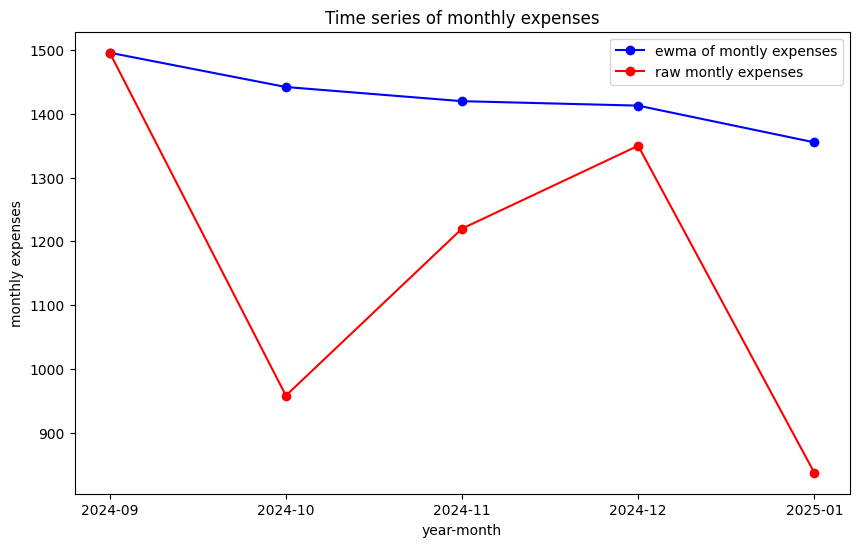

In [57]:
# Analysis of monthly outgoing transactions
monthly_transaction = transaction_df[transaction_df['TIPO TRANSAZIONE'] == 'Uscita']
monthly_transaction.loc[:,'mese_anno'] = monthly_transaction['DATA'].dt.to_period('M')
monthly_transaction = monthly_transaction.groupby('mese_anno')[['IMPORTO']].sum()
monthly_transaction.reset_index(inplace=True)
monthly_transaction['mese_anno'] = monthly_transaction['mese_anno'].astype('str')
monthly_transaction['importo_ewma_05'] = monthly_transaction['IMPORTO'].ewm(alpha=0.1, adjust=False).mean()

# Creare il grafico
plt.figure(figsize=(10, 6))  # Impostare le dimensioni del grafico
plt.plot(monthly_transaction["mese_anno"], monthly_transaction["importo_ewma_05"], 
         marker="o", linestyle="-", color="b", label='ewma of montly expenses')
plt.plot(monthly_transaction["mese_anno"], monthly_transaction["IMPORTO"], 
         marker="o", linestyle="-", color="r", label='raw montly expenses')
plt.xlabel("year-month")
plt.ylabel("monthly expenses")
plt.title("Time series of monthly expenses")
plt.legend(loc='best')




In [64]:
transaction_df.loc[:,'mese_anno'] = transaction_df['DATA'].dt.to_period('M')
pivot_tab = transaction_df.pivot_table(values='IMPORTO', index='mese_anno', columns='TIPO TRANSAZIONE', aggfunc='sum')
print(pivot_tab)
type(pivot_tab)
pivot_tab['cash_flow'] = pivot_tab['Entrata'] - pivot_tab['Uscita']
print(pivot_tab)
pivot_tab.reset_index(inplace=True)
print(pivot_tab.columns)

TIPO TRANSAZIONE  Entrata  Uscita
mese_anno                        
2024-09             400.0  1496.0
2024-10             800.0   958.0
2024-11             800.0  1220.0
2024-12             800.0  1350.0
2025-01               NaN   837.0
TIPO TRANSAZIONE  Entrata  Uscita  cash_flow
mese_anno                                   
2024-09             400.0  1496.0    -1096.0
2024-10             800.0   958.0     -158.0
2024-11             800.0  1220.0     -420.0
2024-12             800.0  1350.0     -550.0
2025-01               NaN   837.0        NaN
Index(['mese_anno', 'Entrata', 'Uscita', 'cash_flow'], dtype='object', name='TIPO TRANSAZIONE')
